In [1]:
import praw
import pandas as pd
import numpy as np
import re
import time
import nltk
import torch
import folium
import spacy
import matplotlib.pyplot as plt

from tqdm import tqdm
from better_profanity import profanity
from textblob import TextBlob
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from geopy.geocoders import Nominatim
from collections import Counter
from folium.plugins import HeatMap

nltk.download("stopwords")
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Task 1

In [2]:
CLIENT_ID = "INSERT CLIENT ID"
CLIENT_SECRET = "INSERT CLIENT SECRET"
USER_AGENT = "INSERT USER AGENT"

reddit = praw.Reddit(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, user_agent=USER_AGENT)

The following code collects posts from selected mental health-related subreddits using specific keywords. It defines a function to clean the text by converting it to lowercase, removing URLs, non-alphanumeric characters, and censoring explicit content. It then retrieves posts containing these keywords, cleans the text, and stores relevant information (ID, timestamp, cleaned text, upvotes, and comments) until 5,000 posts are collected.

In [ ]:
KEYWORDS = ["depressed", "suicidal", "overwhelmed", "hopeless", "self-harm", "panic attack", "anxiety", "lonely"]
SUBREDDITS = ["mentalhealth", "depression", "suicidewatch", "Anxiety", "addiction", "stopdrinking"]

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s\.\'\"]", "", text)  # Keep punctuation
    text = profanity.censor(text)  # Remove explicit content
    return text.strip()

data = []
POSTS_PER_SUBREDDIT = 1000  

for subreddit_name in SUBREDDITS:
    subreddit = reddit.subreddit(subreddit_name)
    
    for keyword in KEYWORDS:
        for post in subreddit.search(keyword, limit=POSTS_PER_SUBREDDIT):
            cleaned_text = clean_text(post.title + " " + post.selftext)
            if len(cleaned_text.split()) > 5:
                data.append([
                    post.id, 
                    post.created_utc, 
                    cleaned_text, 
                    post.score, 
                    post.num_comments
                ])
            
            if len(data) >= 5000:
                break
        if len(data) >= 5000:
            break
    if len(data) >= 5000:
        break

In [5]:
# Removing duplicates
df = pd.DataFrame(data, columns=["Post_ID", "Timestamp", "Content", "Upvotes", "Comments"])
df.drop_duplicates().to_csv("reddit_mental_health_data.csv", index=False)

print(f"{len(df)} posts saved.")

4950 posts saved.


# Task 2

### Sub-task 1

The code applies sentiment analysis to the cleaned content of each Reddit post using TextBlob. It classifies the sentiment as "Positive" if the polarity is greater than 0.1, "Negative" if less than -0.1, and "Neutral" otherwise. The results are stored in a new column and the updated dataset is saved to the same CSV file.

In [7]:
def get_sentiment(text):
    analysis = TextBlob(str(text))
    polarity = analysis.sentiment.polarity  
    return "Positive" if polarity > 0.1 else "Negative" if polarity < -0.1 else "Neutral"

df["Sentiment"] = df["Content"].dropna().apply(get_sentiment)
df.to_csv("reddit_mental_health_data.csv", index=False)

Sentiment
Neutral     2772
Positive    1191
Negative     987
Name: count, dtype: int64


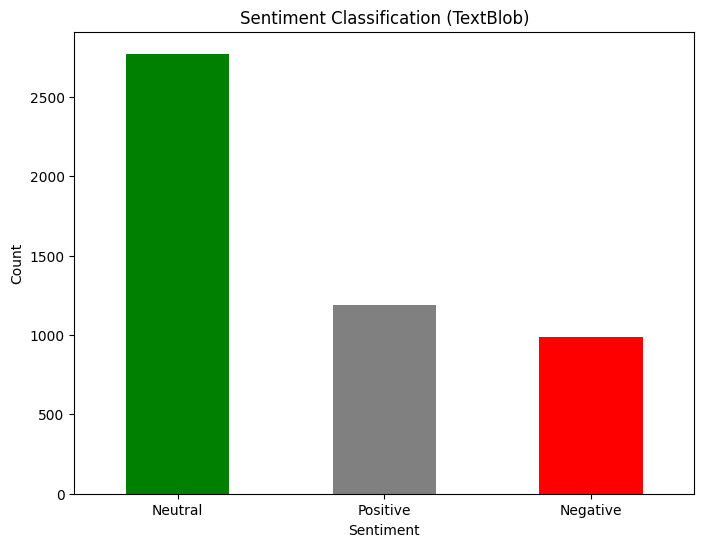


Sample posts with Positive sentiment:

for anyone lonely or struggling with mental health or etc. i know life can be tough. it is for me. i feel alone at school because i have no friends. and the singer from my favorite band passed away. i want you to know that you're not alone and you are loved so any doubt you have in your head needs to go away. i know people have ways of coping with pain and sadness but there's other ways to fix it. maybe i have a problem but i just play the same song over and over again. twice i heard it 7 times in a row. i'm starting to hate it but i'm still listening to it. i just love music and you need to find a hobby to distract you from your pain. the song is called "the acceptance song" it's from the movie "the prom" i've only seen it once and but today after listening to the soundtrack i decide to rewatch it and i left off at
"the acceptance song" scene i want you to know your amazing and special and loved
---
i feel hopeless sometimes hi i dont know where

In [ ]:
# Count occurrences of each sentiment category
sentiment_counts = df["Sentiment"].value_counts()
print(sentiment_counts)

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Classification (TextBlob)")
plt.xticks(rotation=0)
plt.show()

# Display sample posts from each sentiment category
sample_size = 3 
sentiment_classes = ["Positive", "Neutral", "Negative"]

for sentiment in sentiment_classes:
    print(f"\nSample posts with {sentiment} sentiment:\n")
    samples = df[df["Sentiment"] == sentiment]["Content"].dropna().sample(n=min(sample_size, sum(df["Sentiment"] == sentiment))).values
    print("\n---\n".join(samples))

### Sub-task 2

The code uses the SBERT model to compute embeddings for high-risk and moderate-risk keywords, as well as for Reddit posts. It performs clustering on the post embeddings to categorize them into three clusters: High, Moderate, and Low risk. By calculating the similarity between the cluster centroids and the high/ moderate-risk terms, it assigns each cluster a risk label. It then calculates a risk score for each post based on its cosine similarity to high-risk terms. Finally, the updated dataset with the assigned risk levels and scores is saved to a CSV file.

In [11]:
# Load the SBERT model
model = SentenceTransformer("all-MiniLM-L6-v2")

# High-risk and moderate-risk keywords
high_risk_terms = ["self harm", "suicide", "kill myself", "cutting", "hopeless", "want to die", "hurt myself", "no way out", "end it all"]
moderate_risk_terms = ["panic attack", "anxiety", "depressed", "lonely", "not enough", "cry for help", "struggle", "stress"]


In [12]:
# Compute embeddings
high_risk_embeddings = model.encode(high_risk_terms)
moderate_risk_embeddings = model.encode(moderate_risk_terms)
post_embeddings = model.encode(df["Content"].tolist())

# Perform Clustering (3 clusters: High, Moderate, Low)
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(post_embeddings)


In [13]:
# Compute cluster centroids
cluster_centers = kmeans.cluster_centers_

# Compute similarity with high/moderate-risk embeddings
high_risk_similarity = cosine_similarity(cluster_centers, np.mean(high_risk_embeddings, axis=0).reshape(1, -1))
moderate_risk_similarity = cosine_similarity(cluster_centers, np.mean(moderate_risk_embeddings, axis=0).reshape(1, -1))

# Assign risk levels based on similarity
risk_labels = {}
threshold = 0.2
for cluster_id in tqdm(range(num_clusters), desc="Assigning Risk Levels"):
    if high_risk_similarity[cluster_id] - moderate_risk_similarity[cluster_id] > threshold:
        risk_labels[cluster_id] = "High-Risk"
    elif moderate_risk_similarity[cluster_id] - high_risk_similarity[cluster_id] > threshold:
        risk_labels[cluster_id] = "Moderate-Risk"
    else:
        risk_labels[cluster_id] = "Low-Risk"

df["Predicted Risk Level"] = df["Cluster"].map(risk_labels)

Assigning Risk Levels: 100%|██████████| 3/3 [00:00<00:00, 19065.02it/s]


In [21]:
# Assign a Risk Score (0-1 based on similarity to high-risk terms)
risk_scores = []
for emb in tqdm(post_embeddings, desc="Calculating Risk Scores"):
    sim = cosine_similarity([emb], [np.mean(high_risk_embeddings, axis=0)])[0][0]
    risk_scores.append(sim)

df["Risk Score"] = risk_scores

# Save the updated CSV
output_file = "reddit_mental_health_data.csv"
df.to_csv(output_file, index=False)

print(f"Processed file saved as {output_file}")

Calculating Risk Scores: 100%|██████████| 4950/4950 [00:01<00:00, 4031.64it/s]


Processed file saved as reddit_mental_health_data.csv


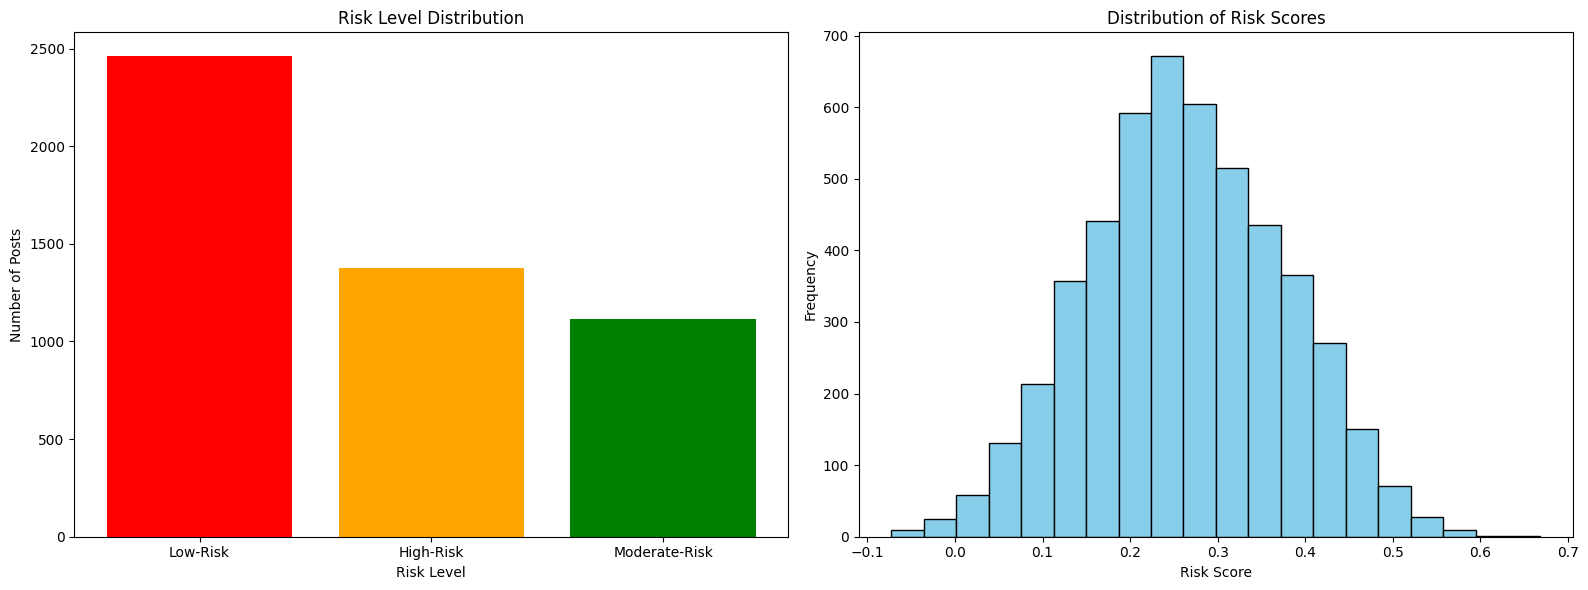


Sample posts of Low-Risk level:

i feel lonely even if i'm not i don't know how to feel.  have a supportive girlfriend one friend and even some members of my family. still i feel lonely feel like no one understands me like i'm not there i mask a lot like always trying to be for everyone even if i feel sad irl. the thing is that i cannot mask anymore and i don't know how to talk about my feelings and when i do nobody seems to understand me maybe i don't express correctly. all i know is that i've feeling blocked for years. right know i'm really anxious and nervous i'm a designer and a tattoo artist and since last week i've been avoiding customers because of my nervousness. i bite my fingers and at this point it does really hurt. sorry for the long  incoherent text. i just needed to vent. i feel like **** and lonely.
---
overwhelmed  38f mom to one 4 year old girl. married my childhood sweetheart but two years ago he threw me into a doorframe went to er with conclusion. now i think i hea

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of Risk Levels
risk_level_counts = df["Predicted Risk Level"].value_counts()
axs[0].bar(risk_level_counts.index, risk_level_counts.values, color=['red', 'orange', 'green'])
axs[0].set_title("Risk Level Distribution")
axs[0].set_xlabel("Risk Level")
axs[0].set_ylabel("Number of Posts")
axs[0].tick_params(axis='x')

# Histogram of Risk Scores
axs[1].hist(df["Risk Score"], bins=20, color='skyblue', edgecolor='black')
axs[1].set_title("Distribution of Risk Scores")
axs[1].set_xlabel("Risk Score")
axs[1].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()

# Display sample posts from each sentiment category
sample_size = 3 
risk_level_classes = ["Low-Risk", "Moderate-Risk", "High-Risk"]

for level in risk_level_classes:
    print(f"\nSample posts of {level} level:\n")
    samples = df[df["Predicted Risk Level"] == level]["Content"].dropna().sample(n=min(sample_size, sum(df["Predicted Risk Level"] == level))).values
    print("\n---\n".join(samples))


# Task 3

The code extracts locations mentioned in Reddit posts using spaCy's Named Entity Recognition (NER). It then geocodes the extracted locations to obtain their latitude and longitude. The locations are counted, and the top 5 most frequent locations are identified. Two maps are created using Folium: one displaying all geocoded locations as a heatmap and another showing the top 5 locations with markers. Both maps are saved as HTML files for visualization.

In [17]:
geolocator = Nominatim(user_agent="crisis_location_extractor", timeout=10)

def extract_locations(text):
    doc = nlp(text)
    return [ent.text.lower() for ent in doc.ents if ent.label_ in ["GPE", "LOC"]]

df["locations"] = df["Content"].apply(extract_locations)

geocoded_locations = []
for locations in df["locations"]:
    for location in locations:
        loc = geolocator.geocode(location)
        if loc:
            geocoded_locations.append((loc.latitude, loc.longitude))

location_counts = Counter(geocoded_locations)
top_locations = location_counts.most_common(5)

In [18]:
m_all = folium.Map(location=[0, 0], zoom_start=2)
HeatMap(geocoded_locations).add_to(m_all)
m_all.save("crisis_heatmap_all_locations.html")

m_top5 = folium.Map(location=[0, 0], zoom_start=2)
for loc, count in top_locations:
    folium.Marker([loc[0], loc[1]], popup=f"{count} mentions", icon=folium.Icon(color="red")).add_to(m_top5)

m_top5.save("crisis_top_5_locations.html")

In [23]:
m_top5

In [22]:
m_all